In [1]:
import os
os.environ["KERAS_BACKEND"] = "theano"

from __future__ import print_function
import numpy as np

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import PIL
from PIL import Image, ImageFilter
import requests
from io import BytesIO

import imp

Using Theano backend.


C:\Users\rames\Documents\GitHub\ai-personas\Personas\personaDefinition_pb2.py
imageInput
transform grey
transform edge
(50L, 50L)
http://www.loc.gov/rr/scitech/subjectguides/images/tesla-new.jpg
transform grey
transform edge
(50L, 50L)
https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/53cfd660e4b089801fe7e3d9/1458152617516/SciSource_BK0929.jpg?format=750w
transform grey
transform edge
(50L, 50L)
https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/53cfd28be4b0c47638e2f540/1458152692173/SciSource_BN4337.jpg?format=750w
(50L, 50L)
https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/5400dbd4e4b0fc8cd2ef213e/1458152745999/SciSource_BU1440.jpg?format=750w
input
transform grey
(50L, 50L)
http://www.loc.gov/rr/scitech/subjectguides/images/tesla-new.jpg
transform grey
(50L, 50L)
https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/53cfd660e4b089801

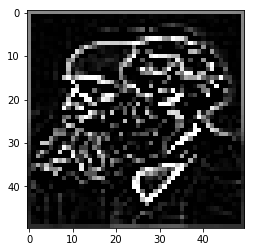

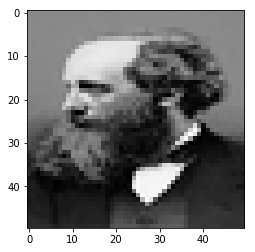

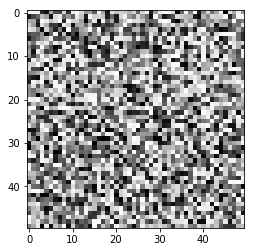

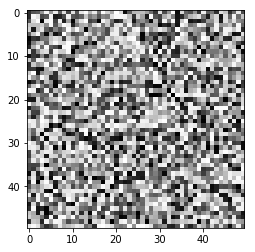

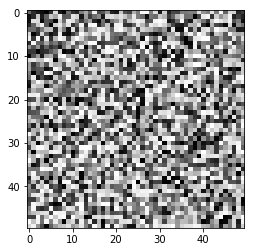

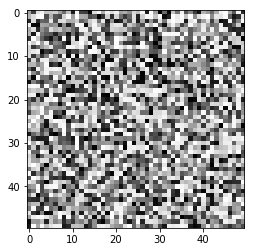

In [2]:
#persona definition
persona_definition_path = os.path.abspath(os.path.join('..', '..', 'Personas', 'personaDefinition_pb2.py'))
print (persona_definition_path)
#import persona proto modules
persona = imp.load_source('Persona', persona_definition_path).Persona()

#load persona
personaName = "Khandhasamy"
personaEvolution=1
personaCategory = ['Artist', 'Portraits', 'sketchToGreyImage'] 
personaPath = os.path.join('..', '..', 'Personas')
for category in personaCategory:
    personaPath = os.path.join(personaPath, category)
persona

#persona file
persona_abs_path = os.path.abspath(os.path.join(personaPath, personaName , personaName + '.bin'))
f = open(persona_abs_path, "rb")
persona.ParseFromString(f.read())

def getInformationSource(persona, layer):
    for environment in persona.age.environments:
        for information in environment.informations:
            for informationConnectedLayerName in information.connectedLayerName:
                if (layer.layerName == informationConnectedLayerName):
                    #print (information.informationSource)
                    return getExtractor(information)

def getExtractor(information):
    #information definition
    information_definition_path = os.path.abspath(os.path.join('..', '..', 'Environment', information.informationSource + "_pb2.py"))
    informationModule = imp.load_source('Information', information_definition_path).Information()  
    information_file_path = os.path.abspath(os.path.join('..', '..', 'Environment', information.informationSource + ".bin"))
    informationFile = open(information_file_path, "rb")
    informationModule.ParseFromString(informationFile.read())
    #load extractor
    information_extractor_path = os.path.abspath(os.path.join('..', '..', 'Environment/Informations/Process/Extract/' + informationModule.extractor + ".py"))
    extractorModule = imp.load_source(informationModule.extractor, information_extractor_path).ImageURLExtractor(informationModule)
    #print (informationModule.extractor)
    return extractorModule

def storeResults(input_data, output_data, dataType):
    if dataType == "image":
        print (output_data.shape)
        print (output_data.shape[0])
        for imgIndex in range(output_data.shape[0]):
            plt.imshow(input_data[imgIndex][0]*255, cmap = cm.Greys_r)
            plt.show()
            plt.imshow(output_data[imgIndex][0]*255, cmap = cm.Greys_r)
            plt.show()

LAYER_CONVOLUTION = "layerConvolution"
LAYER_ACTIVATION = "layerActivation"
LAYER_DROPOUT = "layerDropout"

model = Sequential()

def runPersona(persona):
    x_train_data = None
    y_train_data = None
    x_test_data = None
    input_shape = None
    batch_size = None

    for dna in persona.DNAs:
        for inputLayer in dna.inputs:
            print (inputLayer.layerName)
            inputTransform = inputLayer.inputTransform
            #get information source
            information = getInformationSource(persona, inputLayer)

            x_train_data = information.getTrainingData(inputTransform)
            x_test_data = information.getTestData(inputTransform)
            print ("input")
            
#         for layer in dna.layers:
#             if (LAYER_CONVOLUTION == layer.WhichOneof("SubLayer")):
#                 nb_filters = layer.layerConvolution.filters
#                 convDimension = layer.layerConvolution.convolutionDimension
#                 borderMode = layer.layerConvolution.borderMode
#                 kernelSize = layer.layerConvolution.kernelSize
#                 inputShape = layer.layerConvolution.inputShape
#                 if K.image_dim_ordering() == 'th':
#                     conv_input_shape = (inputShape[0], inputShape[1], inputShape[2])
#                 else:
#                     conv_input_shape = (inputShape[1], inputShape[2], inputShape[0])
#                 if convDimension == 2:
#                     model.add(Convolution2D(nb_filters, kernelSize[0], kernelSize[1],
#                         border_mode=borderMode,
#                         input_shape=conv_input_shape))
#                     print ("conv2D")
#             if (LAYER_ACTIVATION == layer.WhichOneof("SubLayer")):  
#                 activationType = layer.layerActivation.activationType
#                 model.add(Activation(activationType))
#                 print ("activation")
#             if (LAYER_DROPOUT == layer.WhichOneof("SubLayer")):
#                 dropoutPercentage = layer.layerDropout.dropPercentage
#                 model.add(Dropout(dropoutPercentage))
#                 print ("dropout")
                
        for outputLayer in dna.outputs:
            #print (outputLayer.layerName)
            inputTransform = outputLayer.inputTransform
            #get information source
            information = getInformationSource(persona, outputLayer)
            #train data
            y_train_data = information.getTrainingData(inputTransform)
            print ("output")
    
#     #compile model
#     model.compile(loss='binary_crossentropy', optimizer='adadelta')
    
#     print (x_train_data.shape)
#     print (y_train_data.shape)

    
#     #learning
#     batch_size = persona.age.learningBatchSize
#     print (batch_size)
#     nb_epoch = 200
#     model.fit(x_train_data, y_train_data, batch_size=batch_size, nb_epoch=nb_epoch,
#           verbose=1, validation_data=(x_train_data, y_train_data))
    
#     #output for action data
#     y_test_data = model.predict(x_test_data)

    #store test results
    storeResults(x_train_data, y_train_data, "image")
    
runPersona(persona)



In [ ]:
batch_size = 128
nb_classes = 10
nb_epoch = 50

# input image dimensions
img_rows, img_cols = 100, 100
# number of convolutional filters to use
nb_filters = 1
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

In [ ]:


# X_train_data = np.random.random((6,1, img_rows, img_cols))
# Y_train_data = np.random.random((6,1, img_rows, img_cols))

# with open("../../Environment/Informations/Category/Portraits/trainImages/images.txt") as f:
#     infoFileContents = f.readlines()
#     for l in range(len(infoFileContents)):
#         infoLine = infoFileContents[l].lstrip().rstrip()
        
#         print (infoLine)
#         response = requests.get(infoLine)
#         trainInpImg = Image.open(BytesIO(response.content))
#         trainInpGrayImg = trainInpImg.convert("L")
#         trainInpGrayImg = trainInpGrayImg.resize((img_rows,img_cols), PIL.Image.ANTIALIAS)
#         trainInpGreyImgArray = np.asarray(trainInpGrayImg, dtype=np.float32)
#         Y_train_data[l,0,:,:] = trainInpGreyImgArray
        
#         trainInpEdgeImg = trainInpImg.convert("L")
#         trainInpEdgeImg = trainInpEdgeImg.resize((img_rows,img_cols), PIL.Image.ANTIALIAS)
#         trainInpEdgeImg = trainInpEdgeImg.filter(ImageFilter.FIND_EDGES)

#         trainInpEdgeImgArray = np.asarray(trainInpEdgeImg, dtype=np.float32)
#         X_train_data[l,0,:,:] = trainInpEdgeImgArray

# X_test_data = np.random.random((2,1, img_rows, img_cols))
# Y_test_data = np.random.random((2,1, img_rows, img_cols))        

# with open("../../Environment/Informations/Category/Portraits/testImages/images.txt") as f:
#     infoFileContents = f.readlines()
#     for l in range(len(infoFileContents)):
#         infoLine = infoFileContents[l].lstrip().rstrip()
        
#         print (infoLine)
#         response = requests.get(infoLine)
#         trainInpImg = Image.open(BytesIO(response.content))
#         trainInpGrayImg = trainInpImg.convert("L")
#         trainInpGrayImg = trainInpGrayImg.resize((img_rows,img_cols), PIL.Image.ANTIALIAS)
#         trainInpGreyImgArray = np.asarray(trainInpGrayImg, dtype=np.float32)
#         Y_test_data[l,0,:,:] = trainInpGreyImgArray
        
#         trainInpEdgeImg = trainInpImg.convert("L")
#         trainInpEdgeImg = trainInpEdgeImg.resize((img_rows,img_cols), PIL.Image.ANTIALIAS)
#         trainInpEdgeImg = trainInpEdgeImg.filter(ImageFilter.FIND_EDGES)
#         trainInpEdgeImgArray = np.asarray(trainInpEdgeImg, dtype=np.float32)
#         X_test_data[l,0,:,:] = trainInpEdgeImgArray
        

In [ ]:
X_train_data = X_train_data.astype('float32')
X_train_data /= 255
print('X_train shape:', X_train_data.shape)
print(X_train_data.shape[0], 'train samples')
Y_train_data = Y_train_data.astype('float32')
Y_train_data /= 255
print('Y_train shape:', Y_train_data.shape)
print(Y_train_data.shape[0], 'train samples')

In [ ]:
if K.image_dim_ordering() == 'th':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

In [ ]:
model = Sequential()

model.add(Convolution2D(nb_filters*100, kernel_size[0], kernel_size[1],
                        border_mode='same',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Convolution2D(nb_filters*100, kernel_size[0], kernel_size[1],
                         border_mode='same',
                         input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Convolution2D(nb_filters*100, kernel_size[0], kernel_size[1],
                         border_mode='same',
                         input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Convolution2D(nb_filters*100, kernel_size[0], kernel_size[1],
                         border_mode='same',
                         input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                         border_mode='same',
                         input_shape=input_shape))
model.add(Activation('relu'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adadelta')

In [ ]:
model.fit(X_train_data, Y_train_data, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test_data, Y_test_data))

In [ ]:
score = model.evaluate(X_train_data, Y_train_data, verbose=0)
print('Test score:', score)
print('Test accuracy:', score)

In [ ]:
pred_data = model.predict(X_test_data)

In [ ]:
#plot_image = np.concatenate((X_train_data[0][0]*255, Y_train_data[0][0]*255), axis=1)
plt.imshow(X_test_data[0][0]*255, cmap = cm.Greys_r)
plt.show()
plt.imshow(pred_data[0][0]*255, cmap = cm.Greys_r)
plt.show()

In [ ]:
trainInpGrayImg

In [ ]:
trainInpEdgeImg

In [ ]:
prdImg = Image.fromarray(pred_data[0][0], 'L')
prdImg